# Lab Assignment

In this lab assignment, you will improve your skills in scraping data from web pages, organizing the data in a desired format. To do so, we will use data that is provided by the Indeed company via their web pages.


You task will be to exectute the following blocks of code and try to understand what is happening after each line of the code. You will have to answer several questions to show your understanding.

Let us start with importing of the relevant packages.

Warning: I am using Python 3 for this lab assignment. If you are using Python 2, then some libraries may need to be changed., e.g., urllib -> urlib2.

In [1]:
import urllib.request
import urllib.error
import bs4 #this is beautiful soup

import time
from pandas import Series
import pandas as pd
from pandas import DataFrame
import numpy as np
import re

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

As you see, you imported the package called `re`, which supports regular expression operations. You have already used the other packages. 

The following block will access and load the contents of an Indeed.com web page. It will probably give you a warning -- please ignore it.

In [2]:
# Fixed url for job postings containing data scientist
url = 'https://www.indeed.fr/jobs?q=data+scientist&l=%C3%8Ele-de-France'
# read the website
source = urllib.request.urlopen(url).read()
# parse html code
bs_tree = bs4.BeautifulSoup(source)

** Question 1**:
 * What kind of page did you land on? Explain in a few sentences what is the content of this page.
 > Il s'agit du résultat des recherches des offres d'emploi de 'data scientist" en ile de france sur le site indeed
 * What does the "?" and "&" in the url mean?
 > The ? indicates the start of the query string. Within the query string you have a set of key=value pairs, each separated by an &.
 * Explore the content of the web page. If you are using Firefox, open the page Inspector to understand how the underlying html code relates to the displayed content.
 * What pieces of the html code are responsible for showing the job title, company name, and job location?
 > job title : (< h2 class="title">)
 
 > company name : < span class="company">
    
 > job location : ( < div class="location accessible-contrast-color-location" /div>)
    
The following block of code will figure out how many job ads are there for jobs that contain "data scientist' in the job title.

In [3]:
# see how many job postings we found
job_count_string = bs_tree.find(id = 'searchCountPages').contents[0]
job_count_string = job_count_string.split()[-2]
print(("Search yielded %s hits." % (job_count_string)))

# not that job_count so far is still a string, 
# not an integer, and the , separator prevents 
# us from just casting it to int

job_count_digits = [int(d) for d in job_count_string if d.isdigit()]
job_count = np.sum([digit*(10**exponent) for digit, exponent in 
                    zip(job_count_digits[::-1], list(range(len(job_count_digits))))])

print(job_count)

Search yielded 465 hits.
465


** Question 2**:
* What does the "find(id = 'searchCountPages')" in the first line mean?
>find(id = 'searchCountPages') permet de retrouver la partie html id = 'searchCountPages. Son résultat devrait être ( Page 1 de 459 emplois
* What does the second line do?
> La seconde ligne permet de spliter le résultat de la première ligne en une liste [page , 1 , de , 459 , emplois] et de retourner le deuxième élément de la liste en comptant de la fin '459' dans ce cas.

**Question 3**: 
* Write a piece of code that finds the Salary Estimate object on the page
> salary = soup.find_all('span' , class_='salaryText')


The following piece of code allows you to find the links to all the job ads on the page.

In [11]:
# The website is listing 15 results per page, 
# so we need to scrape them page after page
num_pages = int(np.ceil(job_count/10.0))

base_url = 'http://www.indeed.com'
job_links = []
for i in range(2): #do range(num_pages) if you want them all
    url = 'https://www.indeed.fr/emplois?q=data+scientist&l=%C3%8Ele-de-France&start=' + str(i*10)
    html_page = urllib.request.urlopen(url).read() 
    bs_tree = bs4.BeautifulSoup(html_page)
    job_link_area = bs_tree.find(id = 'resultsCol')
    job_postings = job_link_area.findAll("div")
    job_postings = [jp for jp in job_postings if str(jp.get('class')).find('row result')]
    
    job_ids = [jp.get('data-jk') for jp in job_postings]
    
    
    # go after each link
    for id in job_ids:
        if (id != None):
            job_links.append(base_url + '/rc/clk?jk=' + id)

    time.sleep(1)

print("We found a lot of jobs: ", len(job_links))

We found a lot of jobs:  30


**Question 4**:
* explain why is `url` (first line in the for loop) defined as it is. What page are you landing at when `i = 3`?
> l'url est définie comme ceci [url = 'https://www.indeed.fr/emplois?q=data+scientist&l=%C3%8Ele-de-France&start=' + str(i*10)] car si on parcourt les différentes pages pour les annonces "data scientist en ile de france" on remarque que le lien de la première page est https://fr.indeed.com/emplois?q=data+scientist&l=%C3%8Ele-de-France&start= , celui de la dexième page https://fr.indeed.com/emplois?q=data+scientist&l=%C3%8Ele-de-France&start=10 celui de la troisième page https://fr.indeed.com/emplois?q=data+scientist&l=%C3%8Ele-de-France&start=20 etc.... il s'agit donc du lien de base https://www.indeed.fr/emplois?q=data+scientist&l=%C3%8Ele-de-France&start= auquel on ajoute i x 10 sachant que i commence par 0 pour la première page, 1 pour la deuxième etc. Donc pour i=3 on se retrouve sur la quatrième page.
* What does command `bs_tree.find(id = 'resultsCol')` do?
> la commande bs_tree.find(id = 'resultsCol') retourne le tag avec id="resultsCol (The center column on the page where the job postings exist) 

* What does command `''.join(jp.get('class'))` do?
> ''.join(jp.get('class')) Joins all items in [jp.get('class')] into a string
* Explain the properties and content of `job_links`
> job_links est une liste de liens dont l'id est spécifié dans le lien


**Question 5**:
* Reuse the code above to find links to the first 200 listed data science jobs



In [7]:
num_pages = int(np.ceil(job_count/10.0))

base_url = 'http://www.indeed.com'
job_links = []
first_200_job_links = []
for i in range(0,19): 
    url = 'https://www.indeed.fr/emplois?q=data+scientist&l=%C3%8Ele-de-France&start=' + str(i*10)
    html_page = urllib.request.urlopen(url).read() 
    bs_tree = bs4.BeautifulSoup(html_page)
    job_link_area = bs_tree.find(id = 'resultsCol')
    job_postings = job_link_area.findAll("div")
    job_postings = [jp for jp in job_postings if str(jp.get('class')).find('row result')]
    
    job_ids = [jp.get('data-jk') for jp in job_postings]
    
    
    # go after each link
    for id in job_ids:
        if (id != None and len(first_200_job_links)<200):
    
            first_200_job_links.append(base_url + '/rc/clk?jk=' + id)

    time.sleep(1)
    
print( "we found a lot of jobs :" , len(first_200_job_links))
print(first_200_job_links)

we found a lot of jobs : 200
['http://www.indeed.com/rc/clk?jk=342f317f6681028b', 'http://www.indeed.com/rc/clk?jk=3ec6c8a5df61a7cd', 'http://www.indeed.com/rc/clk?jk=90324b40c5502800', 'http://www.indeed.com/rc/clk?jk=cc9b18a4f010fe49', 'http://www.indeed.com/rc/clk?jk=156b21e4e84ad51d', 'http://www.indeed.com/rc/clk?jk=773628dfeae4c442', 'http://www.indeed.com/rc/clk?jk=01c59c24690402fb', 'http://www.indeed.com/rc/clk?jk=cb21be937afa3fc3', 'http://www.indeed.com/rc/clk?jk=cb6c7b39eac6ca22', 'http://www.indeed.com/rc/clk?jk=b19ecb760d62f350', 'http://www.indeed.com/rc/clk?jk=d2c502aabdc78705', 'http://www.indeed.com/rc/clk?jk=01d690bb41abc5fe', 'http://www.indeed.com/rc/clk?jk=3b36493c70267c5c', 'http://www.indeed.com/rc/clk?jk=e2b0ed176860c1a3', 'http://www.indeed.com/rc/clk?jk=992d1405d164319e', 'http://www.indeed.com/rc/clk?jk=d2c502aabdc78705', 'http://www.indeed.com/rc/clk?jk=01d690bb41abc5fe', 'http://www.indeed.com/rc/clk?jk=3b36493c70267c5c', 'http://www.indeed.com/rc/clk?jk=e

The following piece of code accesses and grabs the content of all ads in the `job_links` and extracts all the human-readable text tokens. Then, it counts on how many pages are words `mapreduce`, `spark`, and `visualization` used. It might take a few seconds to execute.

In [12]:
skill_set = {'hadoop':0, 'spark':0, 'python':0}
counter = 0
for link in job_links:
    counter +=1  
    
    try:
        html_page = urllib.request.urlopen(link).read()
    except urllib.error.HTTPError:
        continue
    except urllib.error.URLError:
        continue
    except socket.error as error:
        print("Connection closed")
        continue

    html_text = re.sub("[^a-z.+3]"," ", html_page.decode('utf-8').lower()) # replace all but the listed characters
    
        
    for key in list(skill_set.keys()):
        if key in html_text:  
            skill_set[key] +=1
            
    if counter % 5 == 0:
        print(len(job_links) - counter)
        print(skill_set)
            
print(skill_set)

25
{'hadoop': 0, 'spark': 1, 'python': 3}
20
{'hadoop': 0, 'spark': 4, 'python': 7}
15
{'hadoop': 0, 'spark': 6, 'python': 11}
10
{'hadoop': 0, 'spark': 8, 'python': 15}
5
{'hadoop': 0, 'spark': 10, 'python': 18}
0
{'hadoop': 0, 'spark': 11, 'python': 19}
{'hadoop': 0, 'spark': 11, 'python': 19}


** Question 6**
* What does the `re.sub()` do in the above code? To answer this, you will have to go to the documentation of the regular expression package (find it on web).
> sub-string. re-module. re.sub() renvoie la chaîne obtenue en remplaçant les occurrences sans chevauchement les plus à gauche de la RE dans string par la substitution replacement. Si le motif n'est pas trouvé, string est renvoyée inchangée.
* What is the meaning of `[^a-z.+3]`?
> [^a-z.+3] = les chaines de charactères qui contiennent tout sauf les lettres minuscules de a à z (qui ne sont donc pas des mots) et qui ont une ocurence de 3
* What is the content of `skill_set`?
> skill_set est un dictionnaire qui contient le nombre d'annonces qui requière chacune des compétences hadoop, spark et python


The following piece of code plots the counts of different skills in the processed ads.

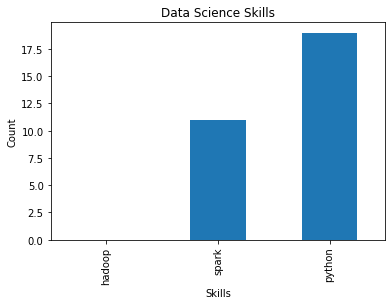

In [13]:
pseries = pd.Series(skill_set)
pseries.sort_values(ascending=False)

pseries.plot(kind = 'bar')
## set the title to Score Comparison
plt.title('Data Science Skills')
## set the x label
plt.xlabel('Skills')
## set the y label
plt.ylabel('Count')
## show the plot
plt.show()

**Question 7**:
- rerun the code to find the counts of the 3 data science skills on the first 200 job ads

In [8]:
skill_set = {'hadoop':0, 'spark':0, 'python':0}
counter = 0
for link in first_200_job_links:
    counter +=1  
    
    try:
        html_page = urllib.request.urlopen(link).read()
    except urllib.error.HTTPError:
        continue
    except urllib.error.URLError:
        continue
    except socket.error as error:
        print("Connection closed")
        continue

    html_text = re.sub("[^a-z.+3]"," ", html_page.decode('utf-8').lower()) # replace all but the listed characters
    
        
    for key in list(skill_set.keys()):
        if key in html_text:  
            skill_set[key] +=1
            
    if counter % 5 == 0:
        print(len(first_200_job_links) - counter)
        print(skill_set)
            
print(skill_set)

195
{'hadoop': 0, 'spark': 1, 'python': 3}
190
{'hadoop': 0, 'spark': 4, 'python': 7}
185
{'hadoop': 0, 'spark': 6, 'python': 11}
180
{'hadoop': 0, 'spark': 8, 'python': 15}
175
{'hadoop': 0, 'spark': 10, 'python': 18}
170
{'hadoop': 0, 'spark': 11, 'python': 19}
165
{'hadoop': 1, 'spark': 12, 'python': 23}


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xb5 in position 11: invalid start byte

## Data analysis of the housing market in the Paris area 

In the first part of the lab, you created `skill_set` dictionary that counts occurences of 3 important data science skills of the jobs in Ile de France. In the second part of this lab, your task will be to create a padas 'DataFrame' object containing information about the flats/houses that are available for rent in the paris area. For each offer, you will have to create columns such as: 
- Location
- Surface
- Number of rooms
- ...

To do so, we will be using seloger.com. Unlike the first part, where you were provided with snippets of codes that help you get familiarized with Web Scrapping skills, in this part you are left on your own to figure out how to do so. You can reduce your search to a specific area of paris, e.g., Paris 9, and for specific range of rent [700 euros,800 euros].

https://www.seloger.com/list.htm?projects=1&types=1,2&places=[{div:2238}]&price=700/800&enterprise=0&qsVersion=1.0

Note: I obtained the above URL by simply using the web page as a human via a browser, and specifying the criteria I needed to via the web form provided by seloger.com


### Deliverable: the modified .ipynb file that contains the answers to the questions